#### Conditional Tb on the CAPE-SUBSAT diagram

In [2]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [3]:
warnings.filterwarnings('ignore')

In [29]:
%%time

stats_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')
year_list = np.arange(2011,2021)

for n,year in enumerate(year_list):
        
    data = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.thetae_sat_lt.full.nc'.format(year))
    if n == 0:
        samples_all_oce = data.samples
        thetae_sat_lt_sum_oce = data.thetae_sat_lt_sum
    else:
        samples_all_oce = samples_all_oce + data.samples
        thetae_sat_lt_sum_oce = thetae_sat_lt_sum_oce + data.thetae_sat_lt_sum

CPU times: user 71.8 ms, sys: 14.1 ms, total: 85.9 ms
Wall time: 85.4 ms


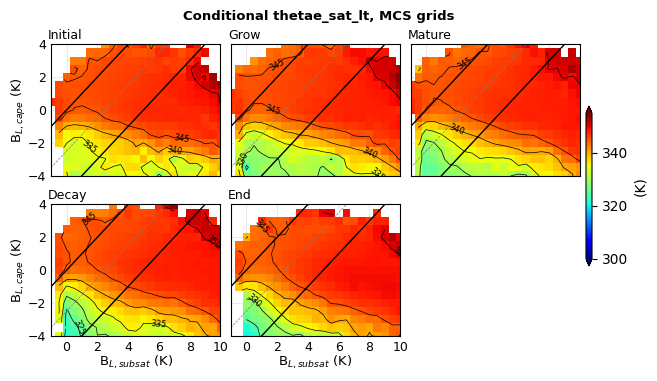

In [30]:
#### contribution of total rainfall 
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

bins_cape = thetae_bl_sum_oce.bins_cape
bins_subsat = thetae_bl_sum_oce.bins_subsat

dbl = 0.25
thetae_sat_lt_sum = thetae_sat_lt_sum_oce.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))
samples_all = samples_all_oce.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

# total samples and rain rate in all phases
samples_allphases = samples_all_oce.sel(area_type='mcs',phase=['Initial','Grow','Mature','Decay','End']).sum(('duration_type','phase'))
total_tb = thetae_sat_lt_sum.sel(area_type='mcs',phase=['Initial','Grow','Mature','Decay','End']).sum(('duration_type','phase'))

for p,(ax,phase,label_str) in enumerate(zip([ax1,ax2,ax3,ax4,ax5],['Initial','Grow','Mature','Decay','End'],
                                            ['(b)','(c)','(d)','(e)','(f)'])):
    
    var_sum = thetae_sat_lt_sum_oce.sel(area_type='mcs', phase=phase).sum('duration_type')
    tmp = samples_all_oce.sel(area_type='mcs', phase=phase).sum('duration_type')
    tmp = tmp.where(tmp > 10)
   
    # conditional mean of gpm precip (mm/hr)
    cp = ax.pcolormesh(tmp.bins_subsat, tmp.bins_cape, var_sum/tmp, cmap='jet',
                     vmin=300,vmax=355,zorder=2)
    cs = ax.contour(tmp.bins_subsat, tmp.bins_cape, var_sum/tmp, colors='k',linewidths=0.5,
                     levels=np.arange(300,355,5),zorder=2)
    ax.clabel(cs, inline=False, fontsize=6)

    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='both')
        cbar.set_label('(K)') 
        
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', ls='-', lw=1)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
    
    ## configuration of tick, labels
    ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-4,4])
    ax.set_xlim([-1,10])  
    
ax2.tick_params('both', length=0, width=1, which='major')
    
ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

# remove axis 6
ax6.axis('off')

plt.suptitle('Conditional thetae_sat_lt, MCS grids', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.4,w_pad=0.01)

plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BL2Dhist_conditional_thetae_sat_lt.pdf',
    bbox_inches='tight',transparent=False)